In [72]:
%reload_ext autoreload
%autoreload 2

### Curation to merge burst unit (Tetrode data)
Two units belong to the same unit if they
1. display similar waveform shape.
2. have similar place field.
3. display asymmetric correlogram.
4. low ISI violation upon merging.
The 4 metrics are plotted against each other. Find outliers, then inspect their amplitude differences.

Due to requirement of (2) place field in confirming pairs [Harris et al., 2001 Temporal Interaction between Single Spikes and Complex Spike Bursts in Hippocampal Pyramidal Cells.], this step is done only to run sessions.
Sleep sessions burst merging will rely on cell tracking (developed by Shijie Gu).

#### -> Before this step, run ```3.manual_curation``` notebook to exclude noise unit.
#### -> After this step, do cell tracking and apply burst merge to sleep data.
Shijie Gu
Aug 30, 2024

### <font color='green'> General Instructions </font>
<div class="alert alert-block alert-success">
    
1. **Interneurons** should have no merging. If there is undefined place field and the waveform looks more symmetric, then it is likely an interneuron. No merging needed.
</div>

In [73]:
import os
import warnings
import datajoint as dj
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# for semi-auto curation
import spyglass.spikesorting.v0 as sgs
from spyglass.spikesorting.v0 import SpikeSorting
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms

from spyglass.decoding.v0.clusterless import UnitMarks #not using data from the table but some functions associated with it

from spyglass.shijiegu.curation_manual import (auto_noise_removal_session,load_metric,load_peak_amp,load_waveforms,
                    plot_spray_window,
                    find_noise_units_by_spike_num,find_noise_units_by_ISI,find_noise_units,
                    plot_metric,plot_peak_amp_overtime,
                    show_plot,show_waveform,
                    insert_CuratedSpikeSorting,
                    end_of_session_check,end_of_day_check)

from spyglass.shijiegu.curation_burst import (get_mean_waveform_r, get_place_field_r,
                isi_violations,isi_all_pairs,get_xcorr_asymmetry,auto_burst_pairs_session,
                insert_CuratedSpikeSorting_burst)

from spyglass.shijiegu.placefield import place_field
from spyglass.shijiegu.load import load_session_name,load_run_sessions

# for plotting waveform
from spyglass.shijiegu.singleUnit import findWaveForms

<div class="alert alert-block alert-info">  
    
### User input (box 1): Animal/Day
</div>

In [3]:
nwb_file_name = 'eliot20221022.nwb'

In [4]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [5]:
run_session_id, run_session_name, pos_session_name = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221022_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221022_ 2         02_Seq2Session pos 1 valid ti
eliot20221022_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221022_ 4         04_Seq2Session pos 3 valid ti
eliot20221022_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221022_ 6         06_Seq2Session pos 5 valid ti
eliot20221022_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221022_ 8         08_Seq2Session pos 7 valid ti
eliot20221022_ 9         09_Seq2Sleep5  pos 8 valid ti
eliot20221022_ 10        10_Seq2Session pos 9 valid ti
eliot20221022_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)



<div class="alert alert-block alert-info">  
    
### User input (box 2): Session index
</div>

In [7]:
session_ind = 0

### Resume running cells

In [8]:
# find one run session
session_name = run_session_name[session_ind]
pos_name = pos_session_name[session_ind]
print(session_name)

02_Seq2Session1


In [202]:
# for that session, for all electrode, find burst pairs. Cache the result.
(fig_m, fig_place, wf_r_all, pf_r_all, isi_violation_all,
     peak_amps_all, ccgs, bins) = auto_burst_pairs_session(nwb_copy_file_name, session_name, pos_name,
                               curation_id = 1, sorter = "mountainsort4",
                               sort_group_ids = None)

working on electrode 0
working on electrode 2
working on electrode 4
working on electrode 5
working on electrode 13
working on electrode 14
working on electrode 16
working on electrode 17
working on electrode 20
working on electrode 23
working on electrode 26
working on electrode 27
working on electrode 28
working on electrode 29
working on electrode 30
working on electrode 31


In [229]:
all_electrodes = list(fig_m.keys())
print(f"All electrodes are: {all_electrodes}")

All electrodes are: [0, 2, 5, 13, 14, 16, 17, 20, 26, 27, 28, 29, 30, 31]


<div class="alert alert-block alert-info">  
    
### User input (box 3): Electrode (sort group)
</div>

In [300]:
sort_group_id = 5

### Resume running cells

In [301]:
# restricting to just this sort group
wf_r = wf_r_all[sort_group_id]
pf_r = pf_r_all[sort_group_id]
ccgs_e = ccgs[sort_group_id]
isi_violation = isi_violation_all[sort_group_id]
peak_amps = peak_amps_all[sort_group_id][0]
peak_amps_t = peak_amps_all[sort_group_id][1]

# load memmap for all units on this electrode, shall be fast
nwb_units,extractor = findWaveForms(nwb_copy_file_name, session_name, sort_group_id)

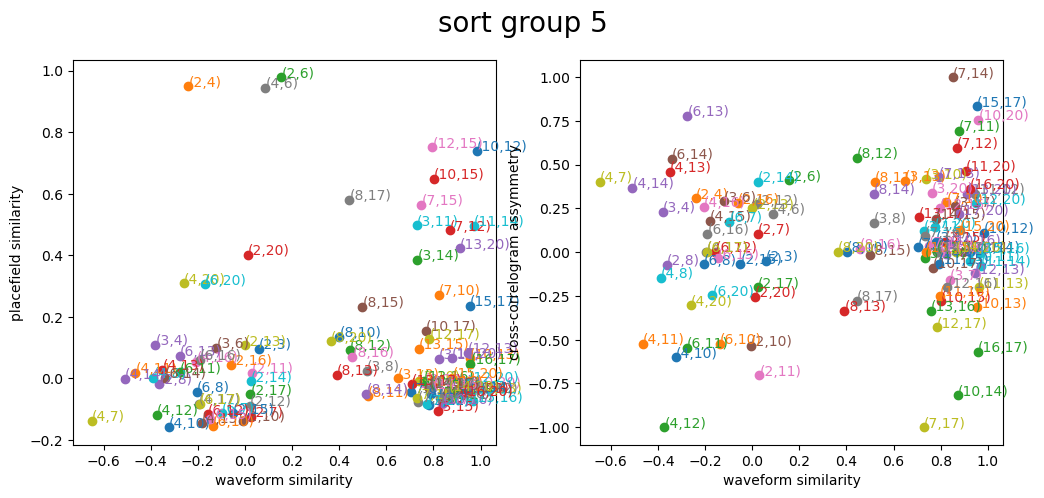

In [302]:
%matplotlib inline
show_plot(fig_m[sort_group_id], f"sort group {sort_group_id}")
# pairs in the upper right part of the plot are the candidates

<div class="alert alert-block alert-info">  
    
### User input (box 4): potential pairs of investigate
</div>

In [304]:
to_investigate_pairs = [(12,15),(10,12),(10,15), # from left panel
                        (7,14),(15,17),(10,20),(7,11),(7,12),(11,20),# from right panel
                       ]

In [ ]:
# show place field

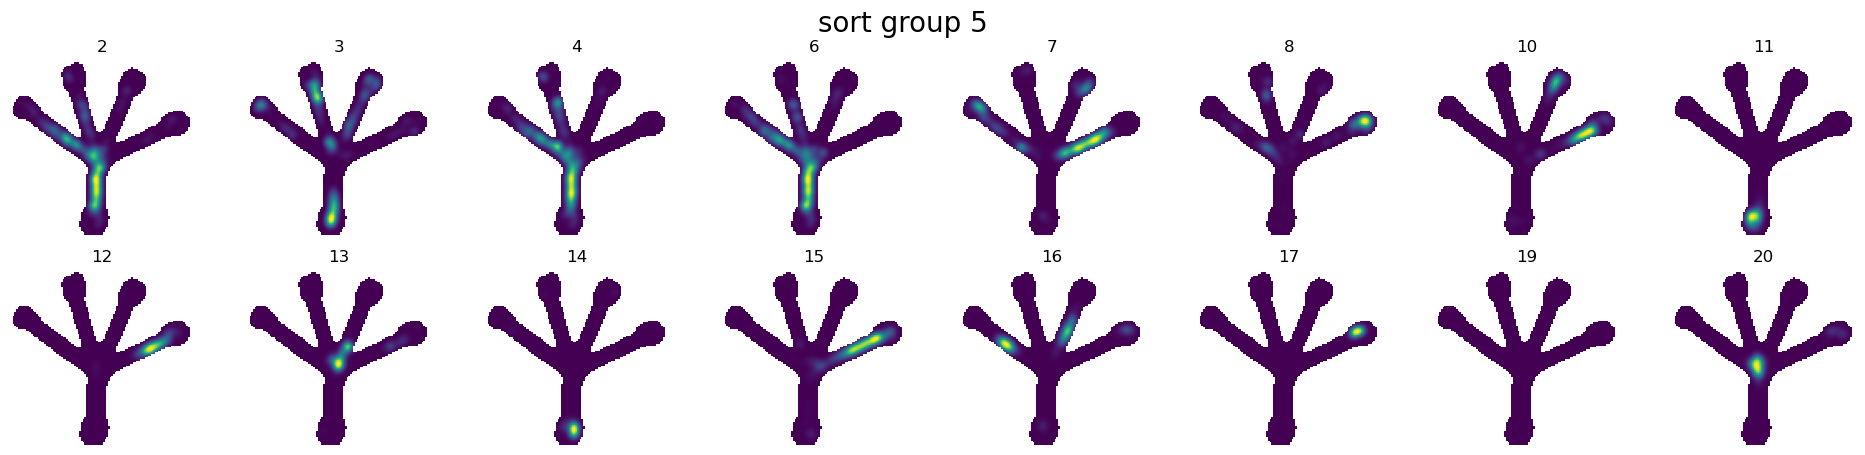

In [305]:
%matplotlib inline
show_plot(fig_place[sort_group_id], f"sort group {sort_group_id}")

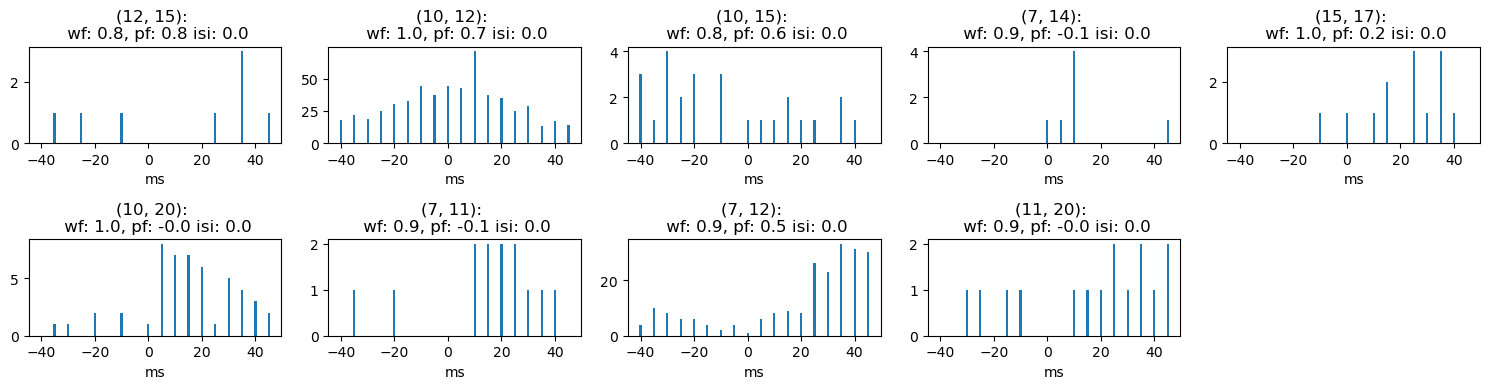

In [306]:
# inspect pair's cross-correlogram
col_num = int(np.ceil(len(to_investigate_pairs)/2))
fig, axes = plt.subplots(2,col_num, figsize = (col_num * 3,4), squeeze = True)

ind = 0
for p in to_investigate_pairs:
    (u1,u2) = p
    axes[np.unravel_index(ind, axes.shape)].bar(bins[1:],ccgs_e[u1-1,u2-1,:])
    axes[np.unravel_index(ind, axes.shape)].set_title(
        f"{p}: \n wf: {np.round(wf_r[p],1)}, pf: {np.round(pf_r[p],1)} isi: {np.round(isi_violation[p],1)}")
    axes[np.unravel_index(ind, axes.shape)].set_xlabel("ms")
    ind = ind + 1

if ind < col_num * 2: #remove the last unused axis
    axes[np.unravel_index(ind, axes.shape)].axis("off")
plt.tight_layout()

Should have consistent decrease/increase across all channels.


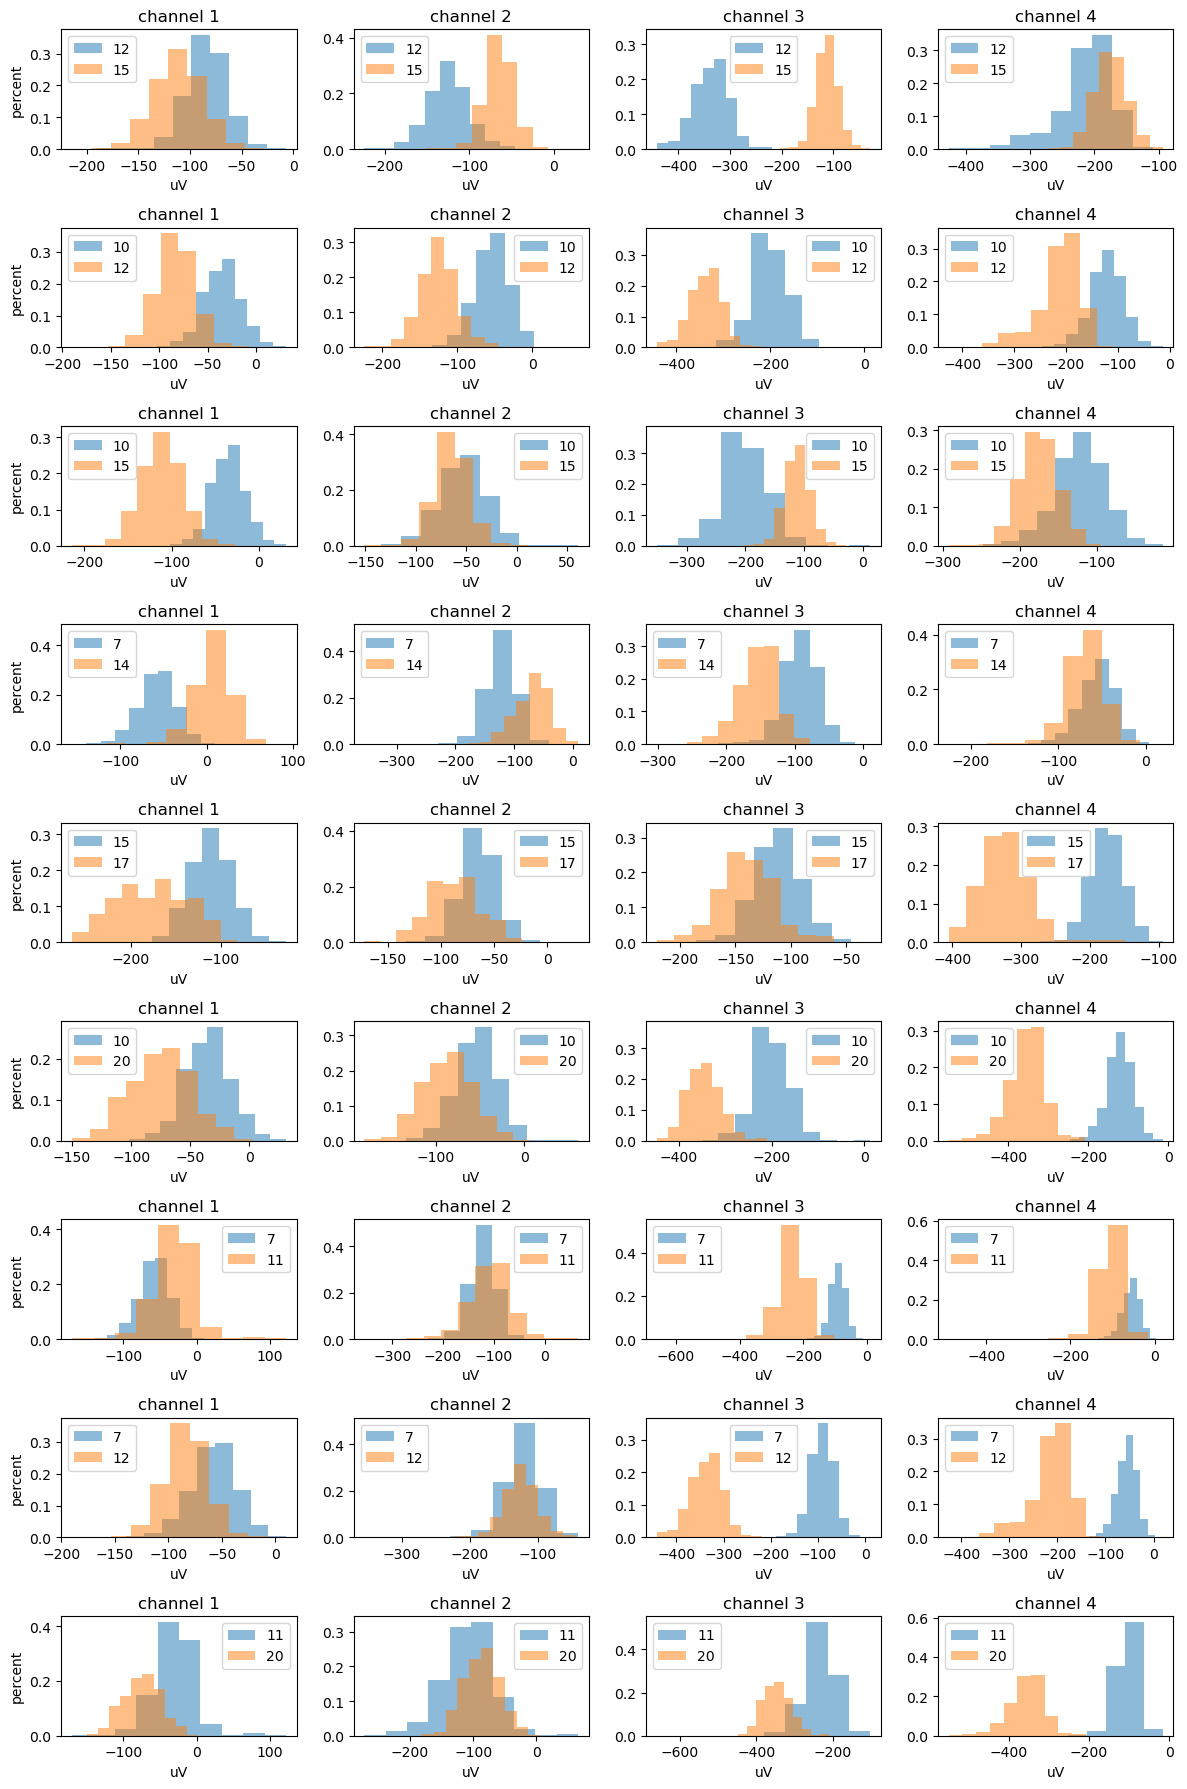

In [307]:
fig,axes=plt.subplots(len(to_investigate_pairs),4,figsize=(12,2 * len(to_investigate_pairs)),squeeze = False)

ind = 0
for p in to_investigate_pairs:
    (u1, u2) = p

    peak1 = peak_amps[u1]
    peak2 = peak_amps[u2]
    
    axes[ind,0].set_ylabel("percent")
    for i in range(4):
        data1 = peak1[:,i]
        data2 = peak2[:,i]
        axes[ind,i].hist(data1,alpha = 0.5,
             weights = np.ones(len(data1))/len(data1),label = str(u1))
        axes[ind,i].hist(data2,alpha = 0.5,
             weights = np.ones(len(data2))/len(data2),label = str(u2))
        axes[ind,i].set_title("channel "+str(i+1))
        axes[ind,i].set_xlabel("uV")
        axes[ind,i].legend()
    ind = ind + 1
plt.tight_layout()
print("Should have consistent decrease/increase across all channels.")

<div class="alert alert-block alert-info">  
    
### User input (box 5): plot amplitude interactive for all final pairs
</div>

In [316]:
further_investigate_pairs = [(7,11),(7,12)] # a list of merge list

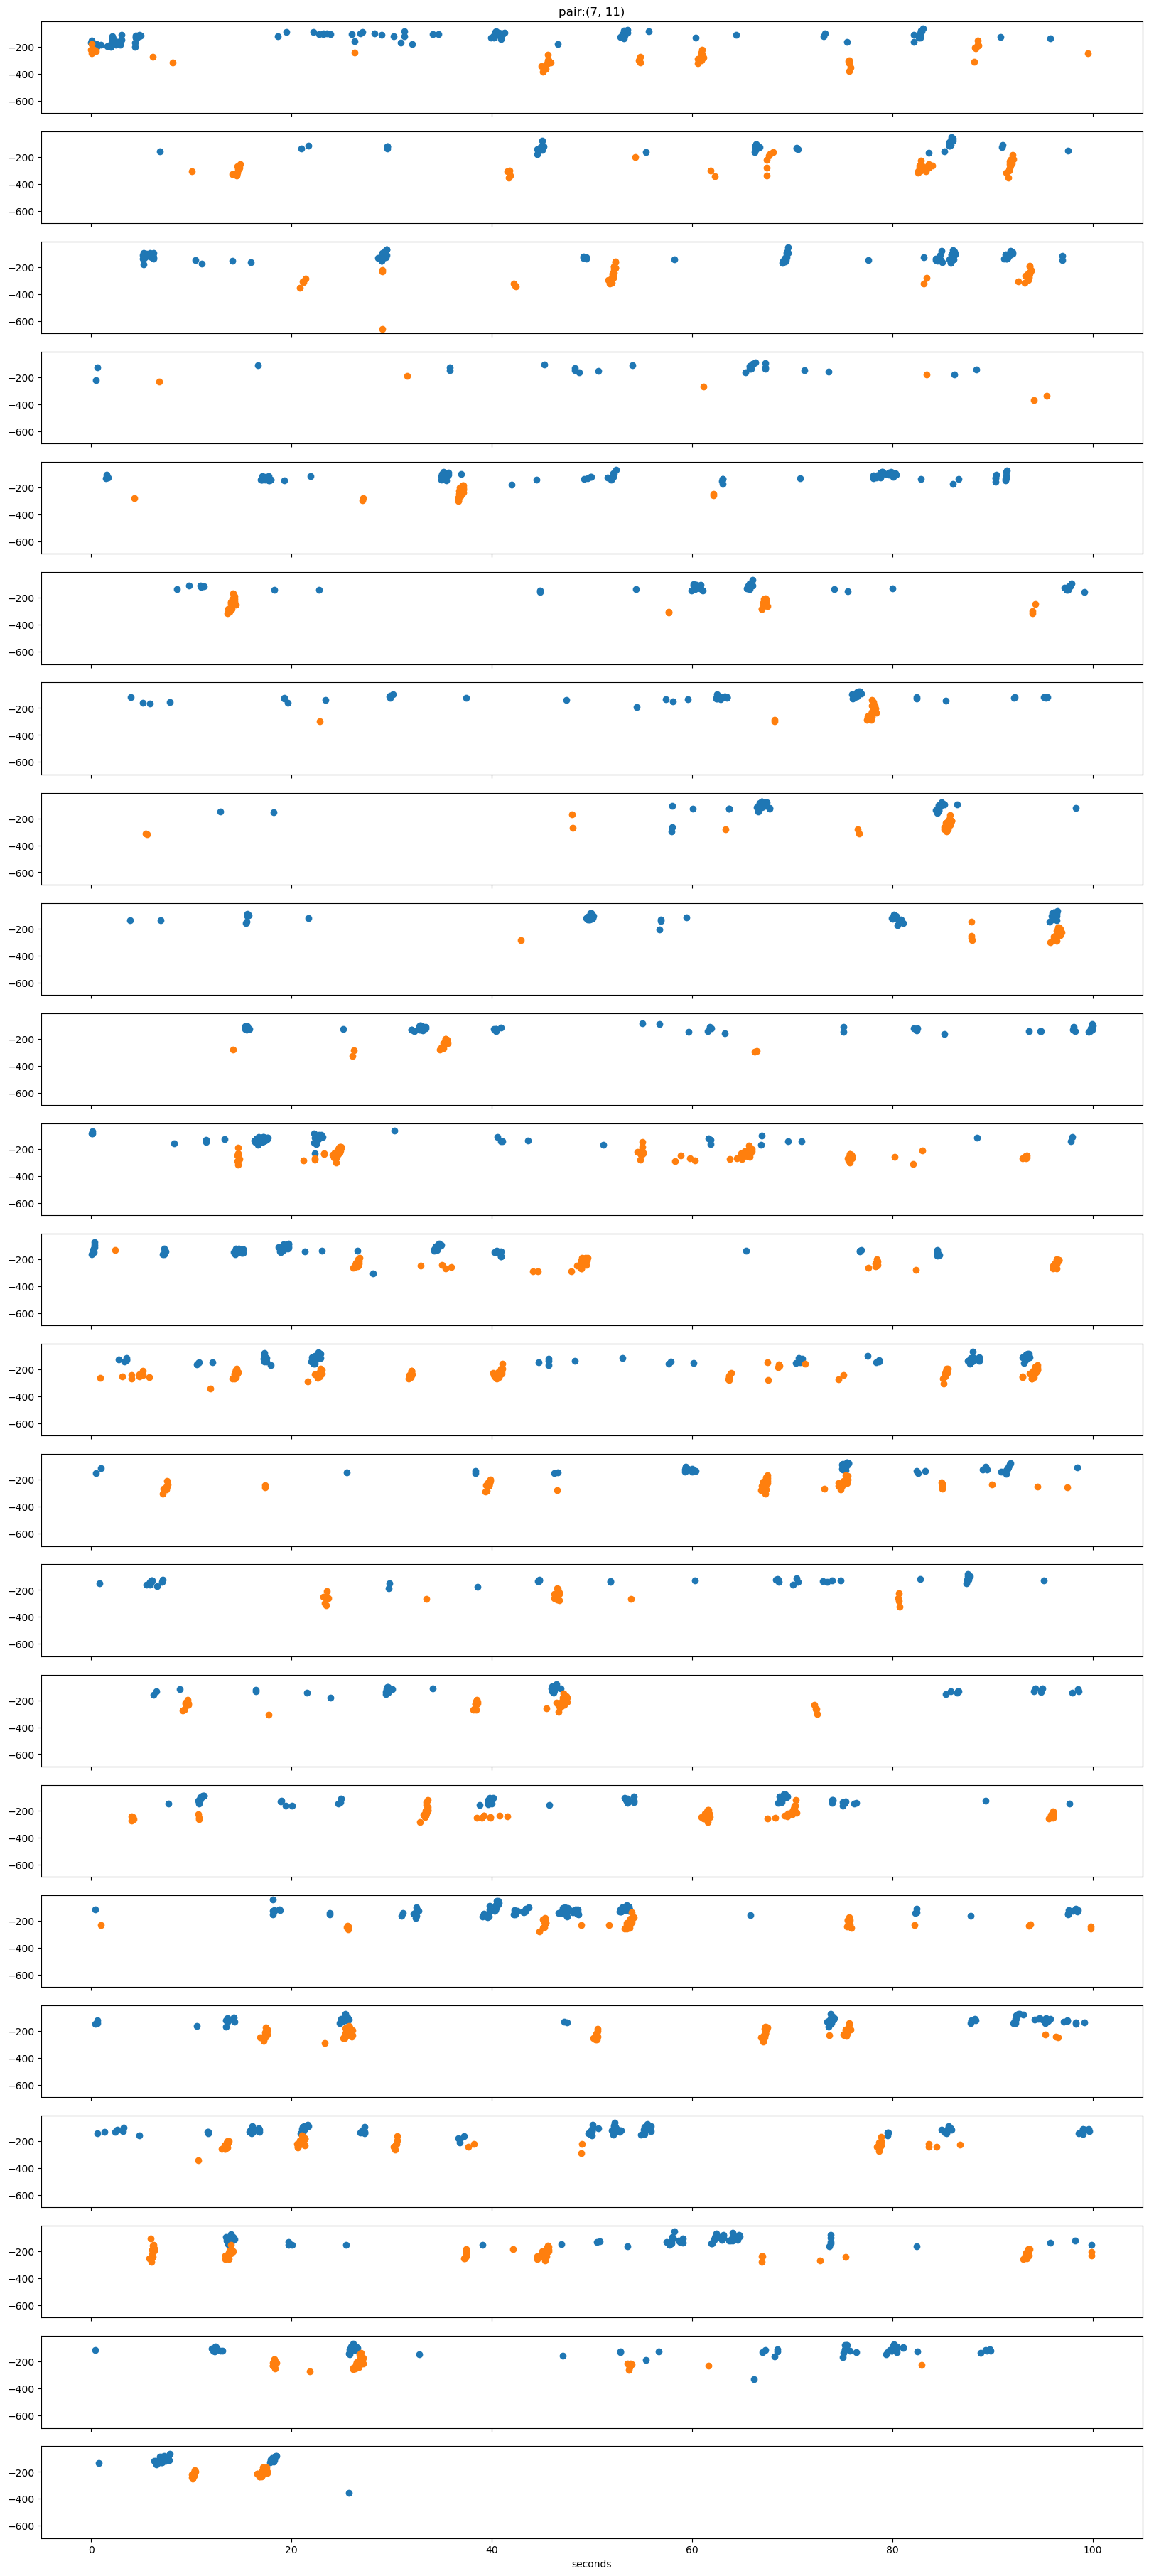

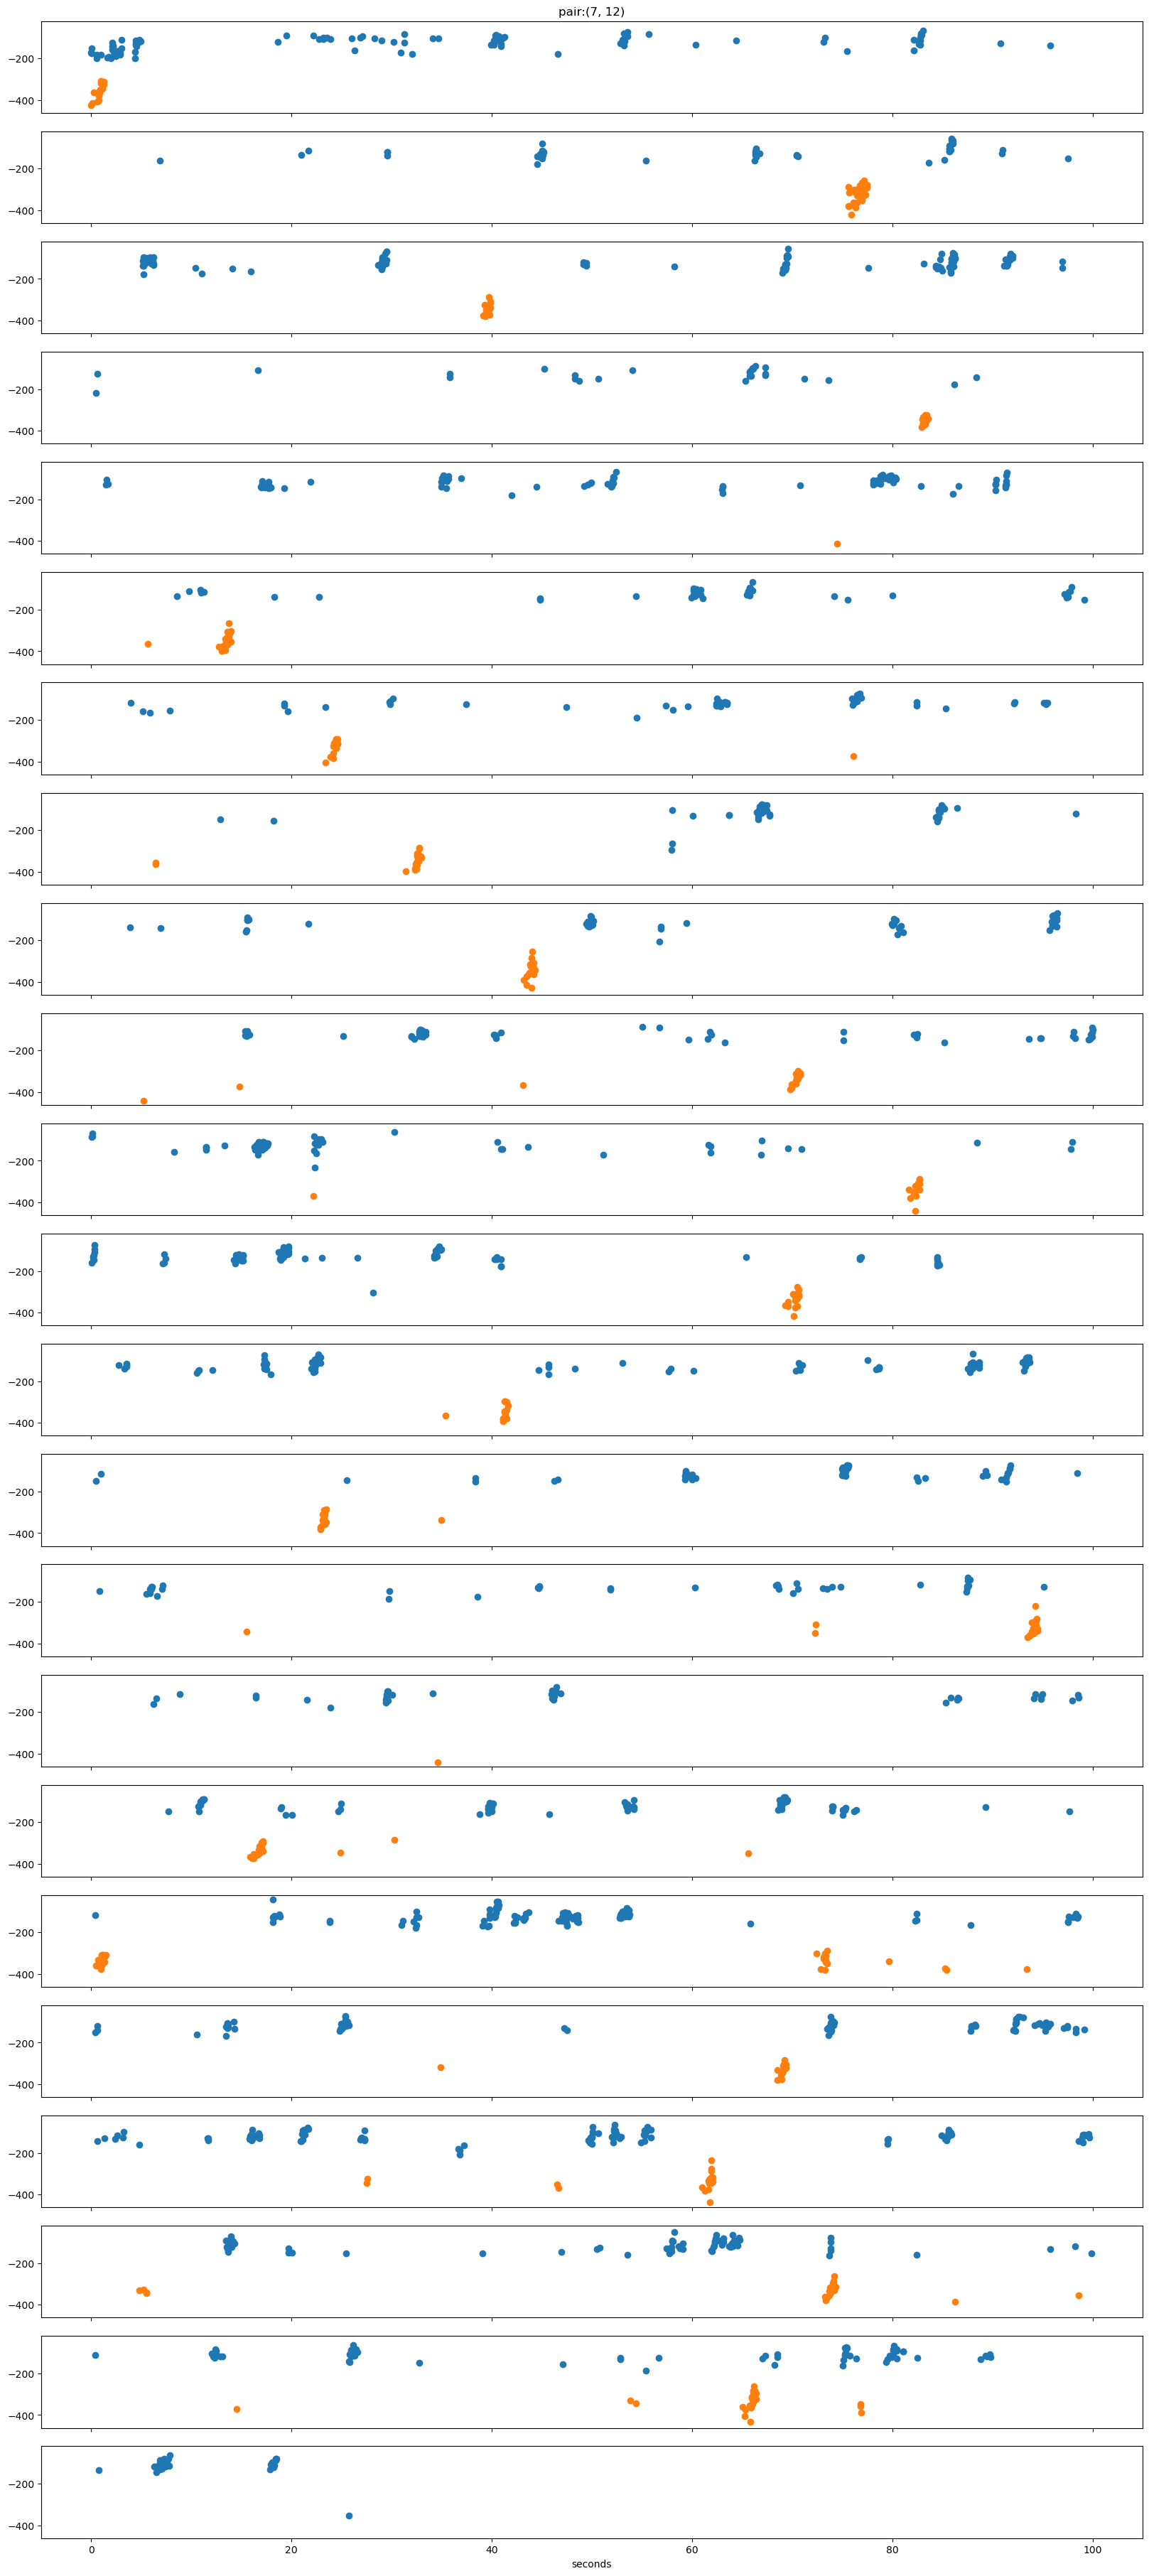

In [317]:
# just to make input into the format the function plot_peak_amp_overtime() wants
peak_V_t = {}
peak_V_t[sort_group_id] = (peak_amps,peak_amps_t)

for pair in further_investigate_pairs:
    fig, axes = plot_peak_amp_overtime(peak_V_t,sort_group_id,pair,overlap = True)
    axes[0,0].set_title(f"pair:{pair}")
    axes[-1,0].set_xlabel("seconds")

<div class="alert alert-block alert-info">  
    
### User: insert into Spyglass
</div>

In [296]:
final_pairs = [(10,20)]

In [297]:
key = insert_CuratedSpikeSorting_burst(nwb_copy_file_name,
                                       session_name, sort_group_id,
                                       final_pairs, parent_curation_id = 1)


[14:26:50][INFO] Spyglass: Found 9 accepted units
[14:26:52][INFO] Spyglass: Writing new NWB file eliot20221022_WYCUSXB8JH.nwb
[14:26:52][INFO] Spyglass: Adding metric snr : [15.96588326 14.65862751 17.79490662 11.66118526 36.58376312 21.59094238
 23.61348343 21.73355865 23.48267174]
[14:26:52][INFO] Spyglass: Adding metric isi_violation : [0.         0.         0.         0.00074442 0.         0.00249377
 0.02205899 0.         0.        ]
[14:26:52][INFO] Spyglass: Adding metric nn_isolation : [0.8472     0.89533898 0.89237288 0.8332     0.99703264 0.97121212
 0.98173913 0.96363636 0.98939394]
[14:26:52][INFO] Spyglass: Adding metric nn_noise_overlap : [0.0029     0.0064     0.00847458 0.0148     0.00089021 0.00646766
 0.0057     0.02272727 0.00782609]
[14:26:52][INFO] Spyglass: Adding metric peak_channel : [53. 53. 53. 53. 54. 55. 55. 55. 55.]
[14:26:52][INFO] Spyglass: Adding metric num_spikes : [ 1823.  2068.   236.  4031.   337.   402. 44246.    66.   115.]
[14:26:54][INFO] Spygla

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[14:26:59][INFO] Spyglass: Writing new NWB file eliot20221022_UAMTSVCTTZ.nwb


In [298]:
# check the target curation_id is now here.
sgs.CuratedSpikeSorting() & key

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,analysis_file_name name of the file,units_object_id
2,eliot20221022_.nwb,13,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221022_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221022_WYCUSXB8JH.nwb,c84bf511-caa5-4fb5-a257-c9b40949b391


<div class="alert alert-block alert-info">  
    
### Optional User input: units to plot waveforms
</div>

In [318]:
to_investigate = [7,11,12]

0
1
2


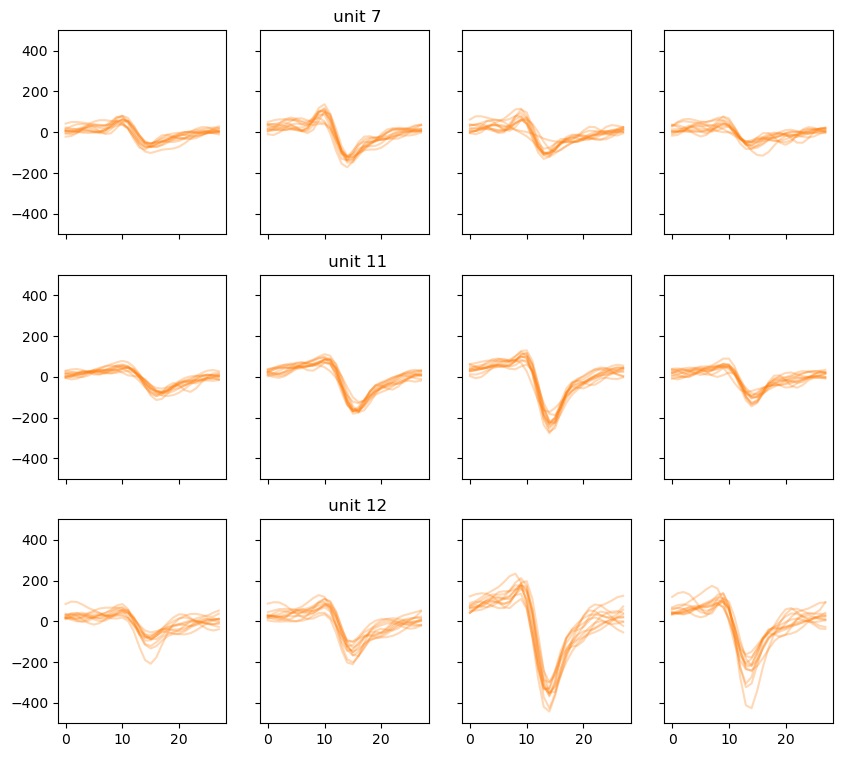

In [319]:
show_waveform(extractor,to_investigate)

### at the end of the session, run this cell

In [299]:
end_of_session_check(nwb_copy_file_name, session_name, parent_curation_id = 1)

02_Seq2Session1 missing sort group [ 0  2  5 27]


0

### at the end of the day, run this cell

In [409]:
end_of_day_check(nwb_copy_file_name, parent_curation_id = 1)

02_Seq2Session1 missing sort group [ 0  2  4  5 31]
missing session ['02_Seq2Session1']


0

<div class="alert alert-block alert-warning">
    
### Extra, if you need to re-investigate an entry
</div>

In [232]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sort_group_id": 23,
       "sorter": "mountainsort4",
       "sort_interval_name": session_name,
       "curation_id":1}

In [310]:
session_valid_t = (IntervalList() & {"interval_list_name":
                   (sgs.SpikeSorting() & key).fetch1("artifact_removed_interval_list_name")}).fetch1("valid_times").ravel()

In [312]:
session_duration = session_valid_t[-1] - session_valid_t[0]

2236.7524552345276

In [234]:
curation_labels = (sgs.Curation() & key).fetch1("curation_labels")

In [241]:
curation_labels[1] = ["accept","mua"]

In [242]:
not_empty = False
for k in curation_labels.keys():
    if 'accept' in curation_labels[k]:
        not_empty = True
        break

In [243]:
not_empty

True

<div class="alert alert-block alert-danger">
    
### Extra, if you need to delete an entry
</div>

In [266]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sort_group_id": sort_group_id,
       "sorter": "mountainsort4",
       "sort_interval_name": session_name,
       "curation_id":2}

In [268]:
#(sgs.Curation() & key).delete()
#(sgs.CuratedSpikeSorting() & key).delete()